# Project 3

Atticus Chong, Evelyn Fuhrman, Keara Hayes, Zachary Malzahn

### Imports and Constants

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import math
import matplotlib.pyplot as plt
import astropy.constants as _ac
import astropy.units as _au
from numpy import pi
from scipy import optimize
from numcheck import within_tolerance

In [2]:
###importing constants

# solar mass, radius, luminosity
Msun = _ac.M_sun.value
Rsun = _ac.R_sun.value
Lsun = _ac.L_sun.value

# physical constants from astropy, all in MKS units
G = _ac.G.value
h = _ac.h.value
hbar = _ac.hbar.value
m_e = _ac.m_e.value
m_p = _ac.m_p.value
m_n = _ac.m_n.value
m_u = _ac.u.value
c = _ac.c.value
kB = _ac.k_B.value
pc = _ac.pc.value
au = _ac.au.value
year = _au.year.to(_au.second)
sigmaSB = _ac.sigma_sb.value

# other constants
mue = 2
K = ((1/5)*((3/(8*pi))**(2/3))*(h**2/(m_e*(mue*m_u)**(5/3))))

In [3]:
from bits_n_pieces import *

### Things and Stuff from Project 2

Functions that aren't altered at all are imported with the script bits_n_pieces.py.

In [4]:
def stellar_derivatives(m, z, mue):
    """
    RHS of Lagrangian differential equations for radius and pressure
    
    Arguments
        m
            current value of the mass
        z (array)
            current values of (radius, pressure)
        mue
            ratio, nucleons to electrons. For a carbon-oxygen white dwarf, mue = 2.
        
    Returns
        dzdm (array)
            Lagrangian derivatives dr/dm, dP/dm
    """
    
    dzdm = np.zeros_like(z)
    
    dzdm[0] = (4*pi*(z[0]**2)*density(z[1],mue))**(-1)
    dzdm[1] = (-G*m)/(4*pi*(z[0]**4))
    
    return dzdm

In [5]:
def central_values(Pc,delta_m,mue):
    """
    Constructs the boundary conditions at the edge of a small, constant density 
    core of mass delta_m with central pressure Pc
    
    Arguments
        Pc
            central pressure (units = ?)
        delta_m
            core mass (units = ?)
        mue
            nucleon/electron ratio
    
    Returns
        z = array([ r, p ])
            central value of radius and pressure (units = ?)
    """
    z = np.zeros(2)
    
    z[0] = ((3*delta_m)/(4 * np.pi * density(Pc, mue)))**(1/3)
    z[1] = Pc   
    return z

In [6]:
def lengthscales(m,z,mue):
    """
    Computes the radial length scale H_r and the pressure length H_P
    
    Arguments
        m
            current mass coordinate (units = kg)
        z (array)
           [ r, p ] (units = [ m, Pa ])
        mue
            mean electron weight
    
    Returns
        z/|dzdm| (units = [ m^6/kg, 1/s^4 ])
    """    
    
    radius = z[0]
    pressure = z[1]
    rho = density(pressure, mue)
    H_r = 4 * np.pi * (radius**3) * rho
    H_p = (4 * np.pi * (radius**4) * pressure) / (G * m) 
    
    out = [H_r, H_p]
    
    out = np.asarray(out)
    
    return out

In [7]:
def integrate(Pc,delta_m,eta,xi,mue,max_steps=10000):
    """
    Integrates the scaled stellar structure equations

    Arguments
        Pc
            central pressure (units = ?)
        delta_m
            initial offset from center (units = ?)
        eta
            The integration stops when P < eta * Pc
        xi
            The stepsize is set to be xi*min(p/|dp/dm|, r/|dr/dm|)
        mue
            mean electron mass
        max_steps
            solver will quit and throw error if this more than max_steps are 
            required (default is 10000)
                        
    Returns
        m_step, r_step, p_step
            arrays containing mass coordinates, radii and pressures during 
            integration (what are the units?)
    """
        
    m_step = np.zeros(max_steps)
    r_step = np.zeros(max_steps)
    p_step = np.zeros(max_steps)
  
    # set starting conditions using central values
    temp = delta_m
    z = central_values(Pc, delta_m, mue)
    Nsteps = 0
    
    for step in range(max_steps):
        radius = z[0]
        pressure = z[1]
        
        # are we at the surface?
        if (pressure < eta*Pc):
            break
            
        # store the step
        m_step[step] = temp
        r_step[step] = radius
        p_step[step] = pressure
        
        # set the stepsize
        h = xi*min(lengthscales(m_step[step], z, mue))

        # take a step
        z = rk4(stellar_derivatives,temp,z,h,args=(mue))
        temp += h
        # increment the counter
        Nsteps += 1
    # if the loop runs to max_steps, then signal an error
    else:
        raise Exception('too many iterations')
        
    return m_step[0:Nsteps],r_step[0:Nsteps],p_step[0:Nsteps]

## 1)

Here, we verify the results from the previous project. $\delta_m$

In [8]:
### these are identical to what we had before since we already had the proper number of sigfigs

delta_m = 1e-4
eta = 1e-20
xi = 0.01

In [9]:
masses = np.arange(0.1, 1.1, 0.1)*Msun
pcs=[]
r_step_list=[]
 
def mass_diff(Pc, m_want, delta_m, eta, mue):
    m_step, r_step, p_step = integrate(Pc,delta_m,eta,xi,mue)
    diff = m_step[-1] - m_want
    return diff

for i in masses:
    out = optimize.bisect(mass_diff, a = 1e19, b = 1e23, xtol=1e-6, args = (i, delta_m, eta, mue))
    m_step, r_step, p_step = integrate(out,delta_m,eta,xi,mue)
    r_step_list.append(r_step[-1])
    pcs.append(out)

In [10]:
pcs=np.asarray(pcs)
r_step_list = np.asarray(r_step_list)
solar_masses = masses / Msun
solar_radii = r_step_list / (Rsun*0.01)

In [11]:
df = pd.DataFrame()

df[r'$\frac{M}{M_{\odot}}$'] = masses / Msun
df[r'$\frac{R}{0.01R_{\odot}}$'] = r_step_list / (Rsun*0.01)
df[r'$P_c (MKS)$'] = pcs
df[r'$\frac{P_c}{(GM^2R^{-4})}$'] = pcs / (G * (masses**2) * (r_step_list**(-4)))
df[r'$\rho (MKS)$'] = density(pcs,mue)
df[r'$\frac{\rho_{c}}{[\frac{3M}{4\pi R^3}]}$'] = density(pcs,mue)/((3 * masses) / (4 * np.pi * (r_step_list**3)))

df

,$\frac{M}{M_{\odot}}$,$\frac{R}{0.01R_{\odot}}$,$P_c (MKS)$,$\frac{P_c}{(GM^2R^{-4})}$,$\rho (MKS)$,$\frac{\rho_{c}}{[\frac{3M}{4\pi R^3}]}$
0,0.1,2.749527,1.517984e+19,0.77014,4.063077e+07,5.990704
1,0.2,2.182301,1.530032e+20,0.77014,1.625231e+08,5.990704
2,0.3,1.906416,5.911141e+20,0.77014,3.656769e+08,5.990704
3,0.4,1.732094,1.542176e+21,0.77014,6.500922e+08,5.990704
4,0.5,1.607933,3.244645e+21,0.77014,1.015769e+09,5.990704
5,0.6,1.513123,5.958057e+21,0.77014,1.462708e+09,5.990704
6,0.7,1.437337,9.960030e+21,0.77014,1.990907e+09,5.990704
7,0.8,1.374764,1.554416e+22,0.77014,2.600369e+09,5.990704
8,0.9,1.321835,2.301842e+22,0.77014,3.291092e+09,5.990704
9,1.0,1.276218,3.270397e+22,0.77014,4.063077e+09,5.990704


### Testing K values

As we can see, changing K does not affect the results.

In [12]:
K = (((1/5)*((3/(8*pi))**(2/3))*(h**2/(m_e*(mue*m_u)**(5/3)))))*2

In [13]:
masses = np.arange(0.1, 1.1, 0.1)*Msun
pcs=[]
r_step_list=[]
 
def mass_diff(Pc, m_want, delta_m, eta, mue):
    m_step, r_step, p_step = integrate(Pc,delta_m,eta,xi,mue)
    diff = m_step[-1] - m_want
    return diff

for i in masses:
    out = optimize.brentq(mass_diff, a = 1e19, b = 1e23, xtol=1e-6, args = (i, delta_m, eta, mue))
    m_step, r_step, p_step = integrate(out,delta_m,eta,xi,mue)
    r_step_list.append(r_step[-1])
    pcs.append(out)

In [14]:
pcs=np.asarray(pcs)
r_step_list = np.asarray(r_step_list)
solar_masses = masses / Msun
solar_radii = r_step_list / (Rsun*0.01)

In [15]:
df = pd.DataFrame()

df[r'$\frac{M}{M_{\odot}}$'] = masses / Msun
df[r'$\frac{R}{0.01R_{\odot}}$'] = r_step_list / (Rsun*0.01)
df[r'$P_c (MKS)$'] = pcs
df[r'$\frac{P_c}{(GM^2R^{-4})}$'] = pcs / (G * (masses**2) * (r_step_list**(-4)))
df[r'$\rho (MKS)$'] = density(pcs,mue)
df[r'$\frac{\rho_{c}}{[\frac{3M}{4\pi R^3}]}$'] = density(pcs,mue)/((3 * masses) / (4 * np.pi * (r_step_list**3)))

df

,$\frac{M}{M_{\odot}}$,$\frac{R}{0.01R_{\odot}}$,$P_c (MKS)$,$\frac{P_c}{(GM^2R^{-4})}$,$\rho (MKS)$,$\frac{\rho_{c}}{[\frac{3M}{4\pi R^3}]}$
0,0.1,2.749527,1.517984e+19,0.77014,4.063077e+07,5.990704
1,0.2,2.182301,1.530032e+20,0.77014,1.625231e+08,5.990704
2,0.3,1.906416,5.911141e+20,0.77014,3.656769e+08,5.990704
3,0.4,1.732094,1.542176e+21,0.77014,6.500922e+08,5.990704
4,0.5,1.607933,3.244645e+21,0.77014,1.015769e+09,5.990704
5,0.6,1.513123,5.958057e+21,0.77014,1.462708e+09,5.990704
6,0.7,1.437337,9.960030e+21,0.77014,1.990907e+09,5.990704
7,0.8,1.374764,1.554416e+22,0.77014,2.600369e+09,5.990704
8,0.9,1.321835,2.301842e+22,0.77014,3.291092e+09,5.990704
9,1.0,1.276218,3.270397e+22,0.77014,4.063077e+09,5.990704


In [16]:
K = (1/5)*((3/(8*pi))**(2/3))*(h**2/(m_e*(mue*m_u)**(5/3)))

## 2)

In [17]:
def mean_molecular_weight(Z,A,X):
    """Computes the mean molecular weight for a fully ionized plasma with an 
    arbitrary mixture of species
    
    Arguments
        Z, A, X (either scaler or array)
            charge numbers, atomic numbers, and mass fractions
            The mass fractions must sum to 1
    """
    Zs = np.array(Z)
    As = np.array(A)
    Xs = np.array(X)
    assert np.sum(Xs) == 1.0
    
    # compute value of mean molecular weight
    mu_array = (Xs/ As)*((1 + Zs))
    mu = np.sum(mu_array)
    mu = mu**-1
    return mu

In [18]:
### testing

def test_chem():
    #scaling for H,He mixture
    for X in [0.0,0.3,0.7,1.0]:
        mu = mean_molecular_weight([1.0,2.0],[1.0,4.0],[X,1.0-X])
        assert within_tolerance(mu,4.0/(5.0*X+3.0))  
        
test_chem()

## 3)

In [19]:
def get_rho_and_T(P,P_c,rho_c,T_c):
    """
    Compute density and temperature along an adiabat of index gamma given a 
    pressure and a reference point (central pressure, density, and temperature).
    
    Arguments
        P (either scalar or array-like)
            value of pressure
    
        P_c, rho_c, T_c
            reference values; these values should be consistent with an ideal 
            gas EOS
    
    Returns
        density, temperature
    """
    gamma=5/3
    # replace with computed values
    rho = rho_c*(P/P_c)**(1/gamma)
    T = T_c*(P/P_c)**(1-1/gamma)

    return rho, T

In [20]:
def test_adiabat():
    rhoc = 1.0e4
    Tc = 1.0e7
    eos_const=4.0
    Pc = eos_const*rhoc*Tc
    Ptest = Pc/10
    gamma = 5/3
    rho, T = get_rho_and_T(Ptest,Pc,rhoc,Tc)
    
    # is P/rho**gamma = const
    assert within_tolerance(Ptest/rho**gamma,Pc/rhoc**gamma),\
        "density does not follow adiabatic relation"
    # is EOS preserved?
    assert within_tolerance(Ptest/rho/T,eos_const),\
        "temperature does not follow adiabatic relation"
    
test_adiabat()

### no error message - test passed

## 4)

In [21]:
def pp_rate(T,rho,XH,pp_factor=1.00):
    """
    Specific heating rate from pp chain hydrogen burning. Approximate rate 
    taken from Hansen, Kawaler, & Trimble.
    
    Arguments
        T, rho
            temperature [K] and density [kg/m**3]
        XH
            mass fraction hydrogen
        pp_factor
            multiplicative factor for rate
    Returns
        heating rate from the pp-reaction chain [W/kg]
    """
    
    T_9 = T/1e9
    
    rate = pp_factor*((2.4e-3*rho*(XH**2))/(T_9**(2/3)))*np.exp(-3.380/(T_9**(1/3)))
    
#     print(rate)
    
    return rate

In [22]:
### testing

def analytical_Texponent(T):
    """Analytical value of the logarithmic derivative of the pp heating rate
    (eq. [4] of the instructions)
    
    Arguments
        temperature [K]
    """
    return (-2 + 3.38/(T*1.0e-9)**(1/3))/3

def Texponent(T,XH,rho,pp_factor,delta=0.0001,):
    """Numerical estimate of the logarithmic derivative of the pp heating rate
    computed via central differencing.
    
    Arguments
        temperature [K]
        hydrogen mass fraction
        mass density [kg m**-3] 
        scaling factor
        fractional difference in temperature
    """
    Thigh = T*(1.0+delta)
    Tlow = T*(1.0-delta)
    r = pp_rate(T,rho,XH,pp_factor)
    rhigh = pp_rate(Thigh,rho,XH,pp_factor)
    rlow = pp_rate(Tlow,rho,XH,pp_factor)
    return T*(rhigh-rlow)/(Thigh-Tlow)/r

def test_pp():
    rho = 1.0e3
    T = 1.0e7
    f = 1.0
    XH = 0.7
    ref_value = 3.8930e-06
    base_rate = pp_rate(T,rho,XH,f)
    rate_XH = pp_rate(T,rho,XH/2,f)
    rate_rho = pp_rate(T,rho*10,XH,f)
    rate_f = pp_rate(T,rho,XH,f*10)
    
    # check against reference value
    assert within_tolerance(base_rate,ref_value,tol=1.0e-4),\
        "rate has incorrect value at T = 1.0e7 K, rho = 1000 kg m**-3, XH = 0.7"
    
    # check scalings with density, hydrogen mass fraction, scale factor
    assert within_tolerance(rate_XH,base_rate/4),\
        "rate does not scale properly with X_H"
    assert within_tolerance(rate_rho,base_rate*10),\
        "rate does not scale properly with rho"
    assert within_tolerance(rate_f,base_rate*10),\
        "rate does not scale properly with pp_factor"

    # check temperature scaling at T = 1.0e7 K and 2.0e7 K
    n_num = Texponent(T,XH,rho,f)
    n = analytical_Texponent(T)
    assert within_tolerance(n_num,n,tol=1.0e-3),\
        "rate has wrong temperature exponent"
    n_num = Texponent(2*T,XH,rho,f)
    n = analytical_Texponent(2*T)
    assert within_tolerance(n_num,n,tol=1.0e-3),\
        "rate has wrong temperature exponent"
test_pp()

In [23]:
Z=[1,2,7]
A=[1,4,14]
X=[0.706,0.275,0.019]
XH=X[0]
mu=mean_molecular_weight(Z,A,X)

## 5)

In [24]:
def central_thermal(m, r, mu):
    """ 
    Computes the central pressure, density, and temperature from the polytropic
    relations for n = 3/2.

    Arguments
        m
            mass in solar units
        r
            radius is solar units
        mu
            mean molecular weight
    Returns
        Pc, rhoc, Tc
            central pressure, density, and temperature in solar units
    """
    
    m = m*Msun
    r = r*Rsun
    
    Pc = 0.77*(G*m**2)/(r**4)
    rhoc = 5.99*((3*m)/(4*np.pi*r**3))
    Tc = 0.54*(mu*m_u/kB)*(G*m/r)
    
    return Pc, rhoc, Tc

In [25]:
### testing

def test_central_thermal():
    Pcs,rhocs,Tcs = central_thermal(1.0,1.0,0.6)
    assert within_tolerance(Pcs,8.675e+14,tol=1.0e-2)
    assert within_tolerance(rhocs,8.445e+03,tol=1.0e-2)
    assert within_tolerance(Tcs,7.413e+06,tol=1.0e-2)
    
    # check scalings with mass, radius by trying 0.5 solar mass, 0.7 solar 
    # radius.
    Pc1, rhoc1, Tc1 = central_thermal(0.5,0.7,0.6)
    assert within_tolerance(Pc1, Pcs*0.5**2/0.7**4)
    assert within_tolerance(rhoc1,rhocs*0.5/0.7**3)
    assert within_tolerance(Tc1,Tcs*0.5/0.7)

test_central_thermal()

## 6)

In [26]:
def stellar_derivatives(m, z, rho, T, mu, XH, pp_factor = 1.0):
    """
    RHS of Lagrangian differential equations for radius and pressure
    
    Arguments
        m
            current value of the mass
        z (array)
            current values of (radius, pressure, luminosity)
        
    Returns
        dzdm (array)
            Lagrangian derivatives dr/dm, dP/dm, dL/dm
    """
    
    dzdm = np.zeros_like(z)
    
    Pc, rhoc, Tc = central_thermal(m, z[0], mu)
    
    dzdm[0] = (4*pi*(z[0]**2)*rho)**(-1)
    dzdm[1] = (-G*m)/(4*pi*(z[0]**4))
    dzdm[2] = pp_rate(Tc, rhoc, XH)
    
#     print(dzdm)
    
    return dzdm

In [27]:
def lengthscales(m, z, rho, T, mu, XH, pp_factor = 1.0):
    """
    Computes the radial length scale H_r and the pressure length H_P
    
    Arguments
        m
            current mass coordinate (units = kg)
        z (array)
           [ r, p, l ] (units = [ m, Pa, W ])
        mue
            mean electron weight
    
    Returns
        z/|dzdm| (units = [ m^6/kg, 1/s^4,  ])
    """    
    
    radius = z[0]
    pressure = z[1]
    luminosity = z[2]
    
    Pc, rhoc, Tc = central_thermal(m, radius, mu)
    
    eps_nuc = pp_rate(Tc, rhoc, XH)
    
    H_r = 4 * np.pi * (radius**3) * rho
    H_p = (4 * np.pi * (radius**4) * pressure) / (G * m) 
    H_l = luminosity / np.abs(eps_nuc)
    
    out = [H_r, H_p, H_l]
    
    out = np.asarray(out)
    
    return out

In [28]:
def central_values(Pc, rhoc, Tc, delta_m, mue, XH, pp_factor = 1.0):
    """
    Constructs the boundary conditions at the edge of a small, constant density 
    core of mass delta_m with central pressure Pc
    
    Arguments
        Pc
            central pressure (units = Pa)
        delta_m
            core mass (units = kg)
        mue
            nucleon/electron ratio
    
    Returns
        z = array([ r, p, l ])
            central value of radius, pressure, and luminosity (units = [m, Pa, ])
    """
    z = np.zeros(3)
    
    z[0] = ((3*delta_m)/(4 * np.pi * rhoc))**(1/3)
    z[1] = Pc  
    z[2] = pp_rate(Tc, rhoc, XH)*delta_m   ### calculate given rhoc and Tc
    return z

In [29]:
def integrate(Pc, rhoc, Tc, delta_m, eta, xi, mue, XH = 0.706, pp_factor = 1.0, max_steps = 10000):
    """
    Integrates the scaled stellar structure equations

    Arguments
        Pc
            central pressure (units = Pa)
        delta_m
            initial offset from center (units = m)
        eta
            The integration stops when P < eta * Pc
        xi
            The stepsize is set to be xi*min(p/|dp/dm|, r/|dr/dm|)
        mue
            mean electron mass
        max_steps
            solver will quit and throw error if this more than max_steps are 
            required (default is 10000)
                        
    Returns
        m_step, r_step, p_step, l_step
            arrays containing mass coordinates, radii and pressures during 
            integration (what are the units?)
    """
        
    m_step = np.zeros(max_steps)
    r_step = np.zeros(max_steps)
    p_step = np.zeros(max_steps)
    l_step = np.zeros(max_steps)
  
    # set starting conditions using central values
    temp = delta_m
    z = central_values(Pc, rhoc, Tc, delta_m, mue, XH)
    Nsteps = 0
    
    for step in range(max_steps):
        radius = z[0]
        pressure = z[1]
        lum = z[2]
        
        # are we at the surface?
        if (pressure < eta*Pc):
            break
            
        # store the step
        m_step[step] = temp
        r_step[step] = radius
        p_step[step] = pressure
        l_step[step] = lum
        
        rho, T = get_rho_and_T(pressure, Pc, rhoc, Tc)
        
        # set the stepsize
        h = xi*np.min(lengthscales(m_step[step], z, rho, T, mu, XH))

        # take a step        
        z = rk4(stellar_derivatives, temp, z, h, args = (rho, T, mu, XH, pp_factor))
        
        temp += h
        
        # increment the counter
        Nsteps += 1
        
    # if the loop runs to max_steps, then signal an error
    else:
        raise Exception('too many iterations')
        
    return m_step[0:Nsteps], r_step[0:Nsteps], p_step[0:Nsteps], l_step[0:Nsteps]

# 7)

We're gonna do this later lol

In [30]:
"""
masses = np.arange(0.1, 1.1, 0.1)*Msun
pcs=[]
r_step_list=[]
 
def mass_diff(Pc, m_want, delta_m, eta, mue):
    m_step, r_step, p_step = integrate(Pc,delta_m,eta,xi,mue)
    diff = m_step[-1] - m_want
    return diff

for i in masses:
    out = optimize.bisect(mass_diff, a = 1e19, b = 1e23, xtol=1e-6, args = (i, delta_m, eta, mue))
    m_step, r_step, p_step = integrate(out,delta_m,eta,xi,mue)
    r_step_list.append(r_step[-1])
    pcs.append(out)
    """

'\nmasses = np.arange(0.1, 1.1, 0.1)*Msun\npcs=[]\nr_step_list=[]\n \ndef mass_diff(Pc, m_want, delta_m, eta, mue):\n    m_step, r_step, p_step = integrate(Pc,delta_m,eta,xi,mue)\n    diff = m_step[-1] - m_want\n    return diff\n\nfor i in masses:\n    out = optimize.bisect(mass_diff, a = 1e19, b = 1e23, xtol=1e-6, args = (i, delta_m, eta, mue))\n    m_step, r_step, p_step = integrate(out,delta_m,eta,xi,mue)\n    r_step_list.append(r_step[-1])\n    pcs.append(out)\n    '

In [31]:
"""
masses = np.arange(0.1, 0.3, 0.05)*Msun
pcs = []
r_step_list = []

def mass_diff(Pc, m_want, delta_m, eta, mue):
    m_step, r_step, p_step, l_step = integrate(Pc, rhoc, Tc, delta_m, eta, xi, mue)
    diff = m_step[-1] - m_want
    return diff

for i in masses:
    pc_out = optimize.bisect(mass_diff, a = 1e19, b = 1e23, xtol=1e-6, args = (i, delta_m, eta, mue))
    m_step, r_step, p_step, l_step = integrate(pc_out,delta_m,eta,xi,mue)
    r_step_list.append(r_step[-1])
    pcs.append(pc_out)
"""

'\nmasses = np.arange(0.1, 0.3, 0.05)*Msun\npcs = []\nr_step_list = []\n\ndef mass_diff(Pc, m_want, delta_m, eta, mue):\n    m_step, r_step, p_step, l_step = integrate(Pc, rhoc, Tc, delta_m, eta, xi, mue)\n    diff = m_step[-1] - m_want\n    return diff\n\nfor i in masses:\n    pc_out = optimize.bisect(mass_diff, a = 1e19, b = 1e23, xtol=1e-6, args = (i, delta_m, eta, mue))\n    m_step, r_step, p_step, l_step = integrate(pc_out,delta_m,eta,xi,mue)\n    r_step_list.append(r_step[-1])\n    pcs.append(pc_out)\n'

In [32]:
"""
pcs=np.asarray(pcs)
r_step_list = np.asarray(r_step_list)
solar_masses = masses / Msun
solar_radii = r_step_list / (Rsun*0.01)
"""

'\npcs=np.asarray(pcs)\nr_step_list = np.asarray(r_step_list)\nsolar_masses = masses / Msun\nsolar_radii = r_step_list / (Rsun*0.01)\n'

In [33]:
"""
df = pd.DataFrame()

df[r'$\frac{M}{M_{\odot}}$'] = masses / Msun
df[r'$\frac{R}{0.01R_{\odot}}$'] = r_step_list / (Rsun*0.01)
df[r'$P_c (MKS)$'] = pcs
df[r'$\frac{P_c}{(GM^2R^{-4})}$'] = pcs / (G * (masses**2) * (r_step_list**(-4)))
df[r'$\rho (MKS)$'] = density(pcs,mue)
df[r'$\frac{\rho_{c}}{[\frac{3M}{4\pi R^3}]}$'] = density(pcs,mue)/((3 * masses) / (4 * np.pi * (r_step_list**3)))

df
"""

"\ndf = pd.DataFrame()\n\ndf[r'$\x0crac{M}{M_{\\odot}}$'] = masses / Msun\ndf[r'$\x0crac{R}{0.01R_{\\odot}}$'] = r_step_list / (Rsun*0.01)\ndf[r'$P_c (MKS)$'] = pcs\ndf[r'$\x0crac{P_c}{(GM^2R^{-4})}$'] = pcs / (G * (masses**2) * (r_step_list**(-4)))\ndf[r'$\rho (MKS)$'] = density(pcs,mue)\ndf[r'$\x0crac{\rho_{c}}{[\x0crac{3M}{4\\pi R^3}]}$'] = density(pcs,mue)/((3 * masses) / (4 * np.pi * (r_step_list**3)))\n\ndf\n"

# 8)

In [34]:
def Teff(Mwant):
    """
    Interpolates effective temperatures given mass from tabulated [1] values 
    for low-mass stars.

    [1] Chabrier, Baraffe, Allard, and Hauschildt. Evolutionary Models for Very 
    Low-Mass Stars and Brown Dwarfs with Dusty Atmospheres. Astrophys. Jour. 
    542:464--472, Oct. 2000.

    Parameters
        Mwant (float, scalar or array)
            Mass of the star(s) in units of solar masses
    Returns

       Teff (float, same type/shape as Mwant)
            Interpolated effective temperatures of the stars in Kelvin.
    """

    # tabulated values from Chabrier et al. (2000)
    masses = np.array([0.1,0.15,0.2,0.3]) # [Msun]
    Teffs = np.array([2800.0,3150.0,3300.0,3400.0]) # [K]
    
    # fill this out to perform interpolation to find Teff for Mwan
    Teff = np.interp(Mwant, masses, Teffs)
    return Teff

In [35]:
def surface_luminosity(Teff,radius):
    """
    Photospheric luminosity [W]
    
    Arguments
        Teff [K]
        radius [m]
    """
    
    # fill this in
    luminosity = (4.0) * (np.pi) * (radius**2) * (sigmaSB) * (Teff**4)
    return luminosity

In [36]:
def test_Teff():
    # does interpolation respect table values?
    for mass,value in zip([0.1,0.15,0.2,0.3],[2800.0,3150.0,3300.0,3400.0]):
        assert Teff(mass) == value
    
    # is interpolation monotonic?
    assert Teff(0.17) > Teff(0.12)
    assert Teff(0.17) > Teff(0.16)
    assert Teff(0.25) > Teff(0.18)
    assert Teff(0.28) > Teff(0.26)

def test_surface_luminosity():
    Teff = 5772.0
    radius = Rsun
    assert within_tolerance(surface_luminosity(Teff,radius),Lsun,tol=1.0e-3)

In [37]:
test_Teff()

test_surface_luminosity()

## 9)

In [38]:
delta_m = Msun*1e-18
eta = 1e-20
xi = 5e-2

In [39]:
masses = np.arange(0.1, 0.35, 0.05)

radii = []
Tcs = []
rhocs = []
sLs = []
Teffs = []

def luminosity_diff(radius_guess, mass, delta_m, eta, xi, mu, pp_rate):
    
    Pc, rhoc, Tc = central_thermal(mass, radius_guess, mu)
    
    m_step, r_step, p_step, l_step = integrate(Pc, rhoc, Tc, delta_m, eta, xi, mue)
    
    T_eff = Teff(mass)
    
    L_calc = surface_luminosity(T_eff,r_step[-1])
    L_nuc = l_step[-1]
    
    L_diff = L_nuc - L_calc
    
    return L_diff

for i in masses:
    r_out = optimize.bisect(luminosity_diff, a = 0.0001, b = 1, xtol=1e-8, args = (i, delta_m, eta, xi, mu, pp_rate))
    
    radii.append(r_out)
    
    Pc, rhoc, Tc = central_thermal(i, r_out, mu)
    
    rhocs.append(rhoc)
    Tcs.append(Tc)
    
    Teffs.append(Teff(i))
    
    sLs.append(surface_luminosity(Teff(i), r_out*Rsun))

## 10)

Text(0, 0.5, 'log(L/L_sun)')

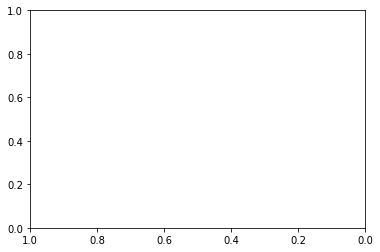

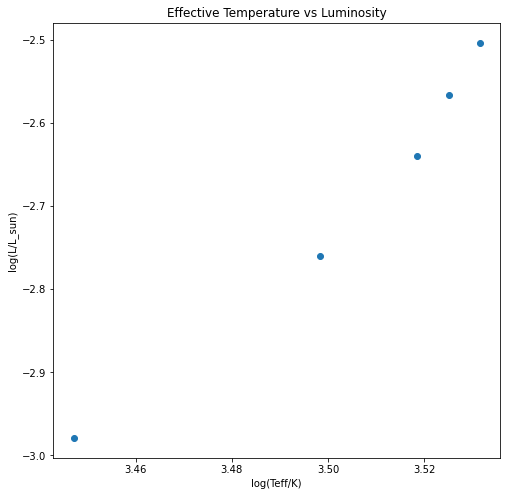

In [42]:
plt.gca().invert_xaxis()

"""
assuming part nine is similar to the cell above (but with a `lum_dif()` function instead of `mass_dif()`), we should
end up with values for luminosity and temperature. Until we have that part running, I'll just write a template code 
that we can run later
"""

# get rad, lum, and Teff values from mass range
masses = np.arange(0.1, 0.35, 0.05)
radii = np.asarray(radii)
Tcs = np.asarray(Tcs)
rhocs = np.asarray(rhocs)
sLs = np.asarray(sLs)
Teffs = np.asarray(Teffs)

# fig, ax = plt.figure(1, figsize = (8, 8))

# scale so everything is relative to the Sun again (except Teffs and central density)
# central density needs to be converted from MKS to CGS 👊🙂 
# solar_masses = masses / Msun
solar_radii = radii / Rsun
solar_lums = sLs / Lsun
# cgs_pcs = pcs * 1000 * 100 # 1000 g/kg, 100 cm/m  

# get logs of stuff
log_lum = np.log10(solar_lums)
log_Teffs = np.log10(Teffs)
log_central_temps = np.log10(Tcs)
# log_cgs_pcs = np.log10(cgs_pcs)

# plot stuff :)
plt.figure(figsize = (8, 8))

# 10.a -- plot log(L/L_sun) vs log(Teff/K). Should resemble HR diagram.
# plt.subplot(121)
plt.scatter(log_Teffs, log_lum)
# plt.invert_xaxis()
plt.title("Effective Temperature vs Luminosity")
plt.xlabel("log(Teff/K)")
plt.ylabel("log(L/L_sun)")

# # 10.b plot log(Tc/K) vs log(rho_c/gcm^-3)
# plt.subplot(122)
# plt.scatter(log_cgs_pcs, log_central_temps)
# plt.title("Central Density vs Central Temperature")
# plt.xlabel("log(rho_c/gcm^-3)")
# plt.ylabel("log(Tc/K)")

#plt.show()